In [1]:
### This noteboook is used for dealing with problem in ContiguousSNP
import sys
import os
import zipfile
from scipy import stats

## import function from python_scripts
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from python_scripts.gene_level_MoM import * 
from python_scripts.pairwise_product_var_calculation import * 
from python_scripts.visualization import * 
from python_scripts.weight_function import * 

In [4]:
###unzip file
zip_files = [
    "../test_data/chr1_Contiguous1KSNP.zip",
    "../test_data/chr1_Random1KSNP.zip"
]
for zf in zip_files:
    with zipfile.ZipFile(zf, "r") as z:
        z.extractall("test_data")   
    print(f"Unzipped: {zf}")
##read data  
##Random snp
RandomSNP = pd.read_csv("test_data/chr1_Random1KSNP.raw", sep=r'\s+')
RandomSNP = RandomSNP.iloc[:, 6:].to_numpy()
##Contiguous snp
ContiguousSNP = pd.read_csv("test_data/chr1_Contiguous1KSNP.raw", sep=r'\s+')
ContiguousSNP = ContiguousSNP.iloc[:, 6:].to_numpy()

Unzipped: ../test_data/chr1_Contiguous1KSNP.zip
Unzipped: ../test_data/chr1_Random1KSNP.zip


#### **Experiment 1**: Use Allel frequency of ith and jth SNP $(p_i, p_j)$ and their covariance $\sigma_{ij}$  to represent pairwise product variance (Var$ Z_i Z_j$). We will use two simulated SNPs and compare their emprical variance and variance calculatged by formula to validate.

In [5]:
# set parameter
n = 2
p1 = 0.3
p2 = 0.4
sigmaij = 0.2
c = sigmaij / n  
p11 = p1 * p2 + c
p10 = p1 - p11
p01 = p2 - p11
p00 = 1 - p11 - p10 - p01

sizes = [1000,10000,100000,1000000,10000000]

for size in sizes:
     ### simulate two SNPs
     probs = np.array([p00, p01, p10, p11])
     codes = np.random.choice(4, size=(size, n), p=probs)
     
     X1 = ((codes == 2) | (codes == 3)).sum(axis=1)
     X2 = ((codes == 1) | (codes == 3)).sum(axis=1)
     X = np.column_stack((X1, X2))
     Z = (X - X.mean(axis=0)) / X.std(axis=0)
     var_zizj_formule= calculate_varZiZj(X)[0]
     empirical_var_zizj= np.var(Z[:,0]*Z[:,1])

     ### compare their result
     print(" ")
     print(f"Under the size of individual:{size}")
     print(f"The var(zizj) given by formule:{var_zizj_formule}")
     print(f"The empirical var(zizj):{empirical_var_zizj}")
     print(f"The relative error:{(var_zizj_formule - empirical_var_zizj) / empirical_var_zizj:.6f}")

 
Under the size of individual:1000
The var(zizj) given by formule:1.0821074793449237
The empirical var(zizj):1.1048484435728123
The relative error:-0.020583
 
Under the size of individual:10000
The var(zizj) given by formule:1.0747274883315807
The empirical var(zizj):1.0840534174604655
The relative error:-0.008603
 
Under the size of individual:100000
The var(zizj) given by formule:1.0780904088916243
The empirical var(zizj):1.0781280383308671
The relative error:-0.000035
 
Under the size of individual:1000000
The var(zizj) given by formule:1.07853249628018
The empirical var(zizj):1.0774532197749014
The relative error:0.001002
 
Under the size of individual:10000000
The var(zizj) given by formule:1.0795297072917682
The empirical var(zizj):1.0795318489713448
The relative error:-0.000002


#### **Experiment 1 Summary**: As sample size increases, the formula-based variance converges to the empirical variance, with relative error dropping to ~0.01% at 10M individuals. This validates the correctness of the closed-form expression for Var$(Z_i Z_j)$

#### **Experiment 2**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by ploting the overall distribution of pairwise product variance Var$(Z_i Z_j)$.

------------------RandomSNP distribution-------------------


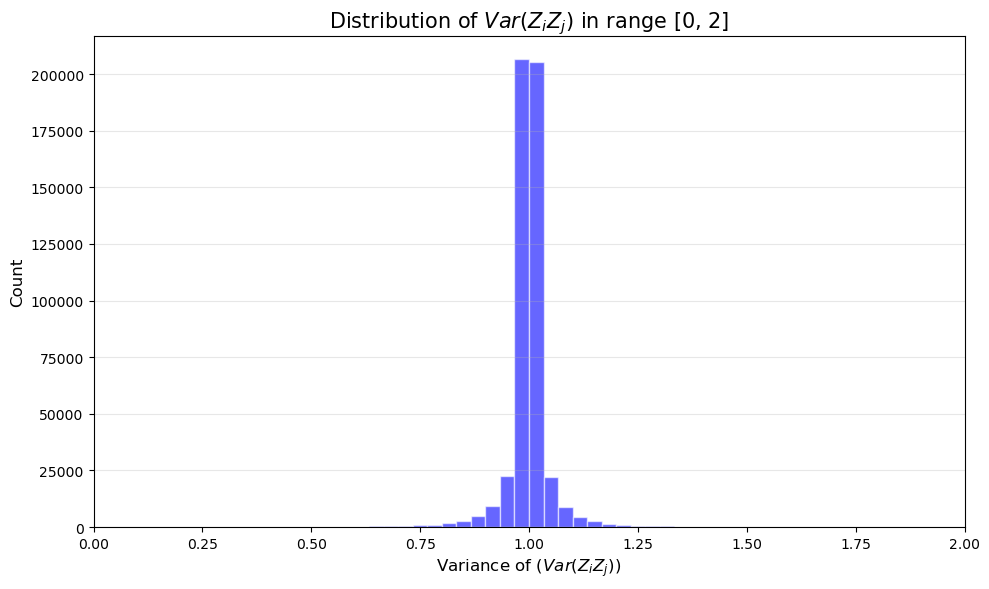

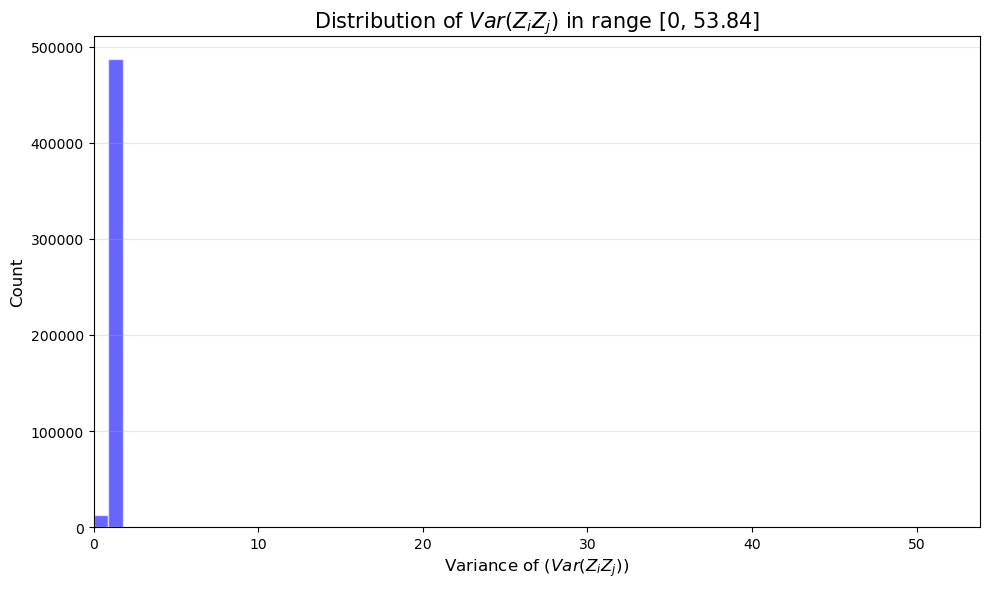

------------------ContiguousSNP distribution-------------------


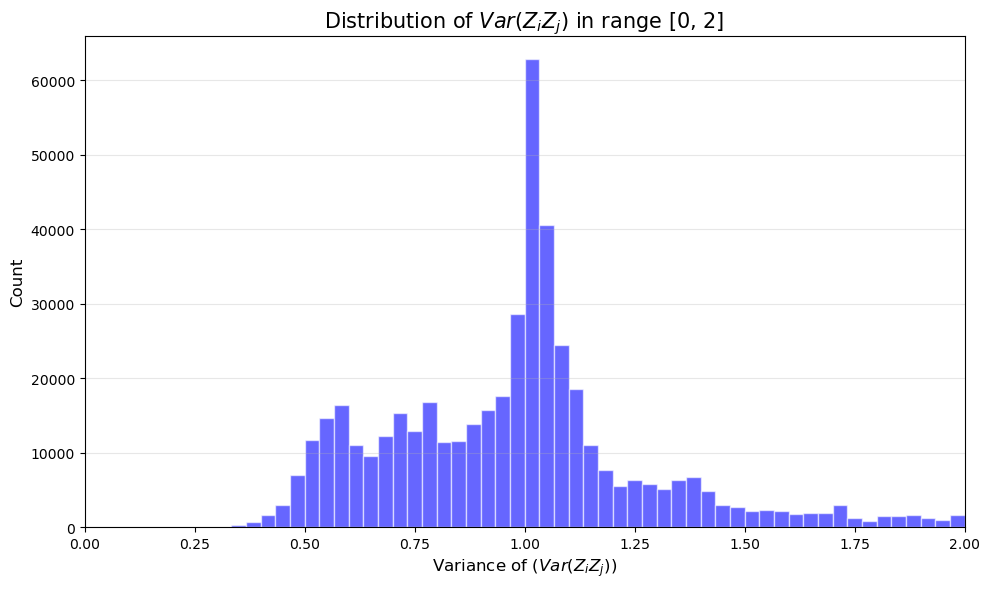

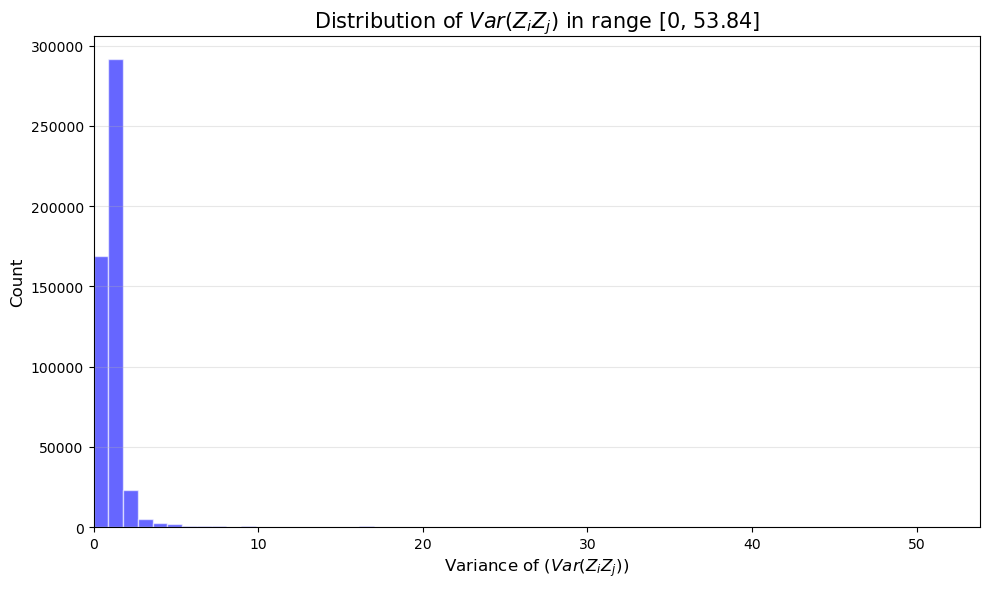

In [6]:
RandomSNP_varZiZj= calculate_varZiZj(RandomSNP)
ContiguousSNP_varZiZj= calculate_varZiZj(ContiguousSNP)

RandomSNP_varXiXj= calculate_varXiXj(RandomSNP)
ContiguousSNP_varXiXj= calculate_varXiXj(ContiguousSNP)

### draw the distribution
print("------------------RandomSNP distribution-------------------")
plot_distribution_varzizj(RandomSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(RandomSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60)  ## draw the distriburion of all variance  
print("------------------ContiguousSNP distribution-------------------")
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,2,60) ## pick variance with range 0 to 2 
plot_distribution_varzizj(ContiguousSNP_varZiZj,0,round(max(ContiguousSNP_varZiZj), 2),60) ## draw the distriburion of all variance

#### **Experiment 2 Summary**: Contiguous SNPs exhibit heavier tails with more extreme variance values compared to random SNPs, and the distribution is skewed.

#### **Experiment 3**: Investigate why the MoM estimator produces biased results with contiguous SNPs compared to random SNPs, by examining the distribution of pairwise product variance Var$(Z_i Z_j)$ and the LD ($r_{ij}$).

------------------RandomSNP case-------------------


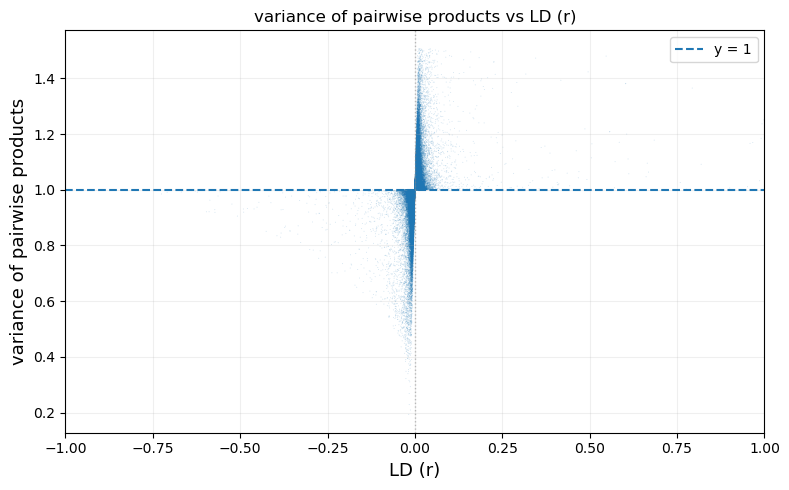

------------------ContiguousSNP case-------------------


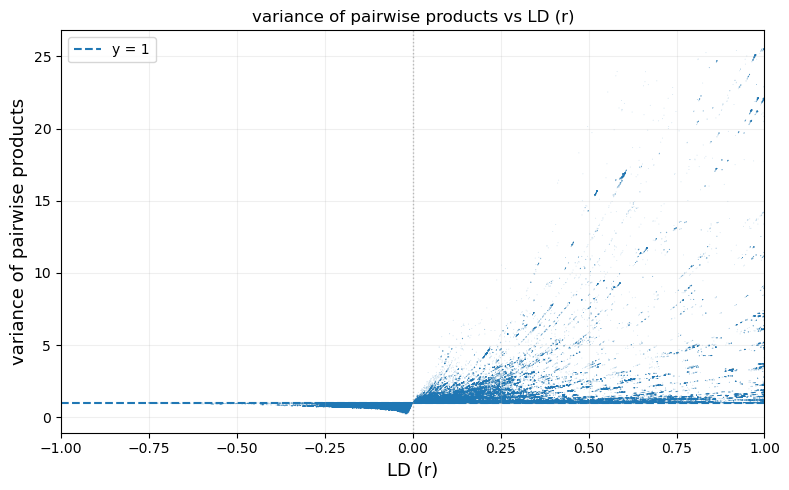

In [7]:
### experiment3: check the distibution of pairwise product variance (var zizj) against with LD (r)
def ld_vector(X):
    corr_matrix = np.corrcoef(X, rowvar=False)
    iu = np.triu_indices(X.shape[1], k=1)
    return corr_matrix[iu]


print("------------------RandomSNP case-------------------")
ld_RandomSNP =  ld_vector(RandomSNP)
plot_var_pairwise_products_against_ld(RandomSNP_varZiZj, ld_RandomSNP, q=0.999, save_path=None)


print("------------------ContiguousSNP case-------------------")
ld_ContiguousSNP =  ld_vector(ContiguousSNP)
plot_var_pairwise_products_against_ld(ContiguousSNP_varZiZj, ld_ContiguousSNP, q=0.999, save_path=None)

#### **Experiment 3 Summary**: High LD (particularly positive correlation) between Contiguous SNPs is the main factor behind inflated Var$(Z_i Z_j)$, which in turn biases the MoM estimator.

#### **Experiment 4**:

We investigate three factors that may affect gxg heritability ($h^2_{g \times g}$) estimation: linkage disequilibrium (LD), minor allele frequency (MAF), and number of SNPs. We categorize our test data into 12 groups using the following criteria:

**LD levels (3 bins):**
- High LD: SNPs pruned at $r^2 > 0.9$
- Medium LD: SNPs pruned at $r^2 > 0.5$
- Low LD: SNPs pruned at $r^2 > 0.2$

**MAF thresholds (2 bins):**
- All variants: no MAF filtering
- Common variants: MAF ≥ 0.05

**SNP number (2 bins):**
- Small dataset: 600 SNPs
- Large dataset: 1800 SNPs

We examine how these factors influence estimation bias and standard error of $\hat h^2_{g \times g}$.

In [ ]:
### Read all data
individual_sizes = [1000,2000,4000,8000]
##high-LD group
highLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_largeDataset_allVariants",1800)
highLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_largeDataset_commonVariants",1800)
highLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_smallDataset_allVariants",600)
highLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","highLD_smallDataset_commonVariants",600)

##middle-LD group
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_largeDataset_allVariants",1800)
middleLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_largeDataset_commonVariants",1800)
middleLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_smallDataset_allVariants",600)
middleLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","middleLD_smallDataset_commonVariants",600)

##low-LD group
lowLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_largeDataset_allVariants",1800)
lowLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_largeDataset_commonVariants",1800)
lowLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_smallDataset_allVariants",600)
lowLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","lowLD_smallDataset_commonVariants",600)

#### **Experiment 4.1**:
We first invetigate the influence of LD level.

**Hypothesis**:  The level of LD influences the biasness of the epistatic heritability estimator $\hat{h}^2_{g \times g}$, The higher the LD level, the greater the bias of the estimator.

**Simple Inference**: We got the formule that use Allel frequency of ith and jth SNP $(p_i, p_j)$ and their covariance $\sigma_{ij}$  to represent pairwise product variance (see below)

$$
\text{Var}(Z_i Z_j) = 1 + \frac{\sigma_{ij}(1 - 2p_i)(1 - 2p_j)}{4p_i p_j (1 - p_i)(1 - p_j)}
$$

When two SNPs are independent($r^2 =0, \sigma_{ij} = 0$),  their pairwise product has unit variance $\text{Var}(Z_i Z_j) = 1$. Extending this to a full dataset, if all SNPs in a standardized genotype matrix are mutually independent, then all pairwise products will have unit variance.

Standardization (zero mean, unit variance) ensures that each SNP contributes equally to the genetic relationship matrix, yielding unbiased estimates. Similarly, for epistatic heritability estimation, we want each pairwise product variance to be unit variance so that they contributes equally to the genetic relationship matrix.

However, due to the presence of LD, even after standardizing the genotype matrix, the pairwise product variance will still be inflated or deflated depending on the covariance,excepet one of the SNP has AF =0.5.


**Test**:
We compared three datasets with different LD levels to examine the influence of LD on estimation bias: highLD_large_all, middleLD_large_all, and lowLD_large_all. These datasets differ only in the LD pruning threshold applied during quality control.

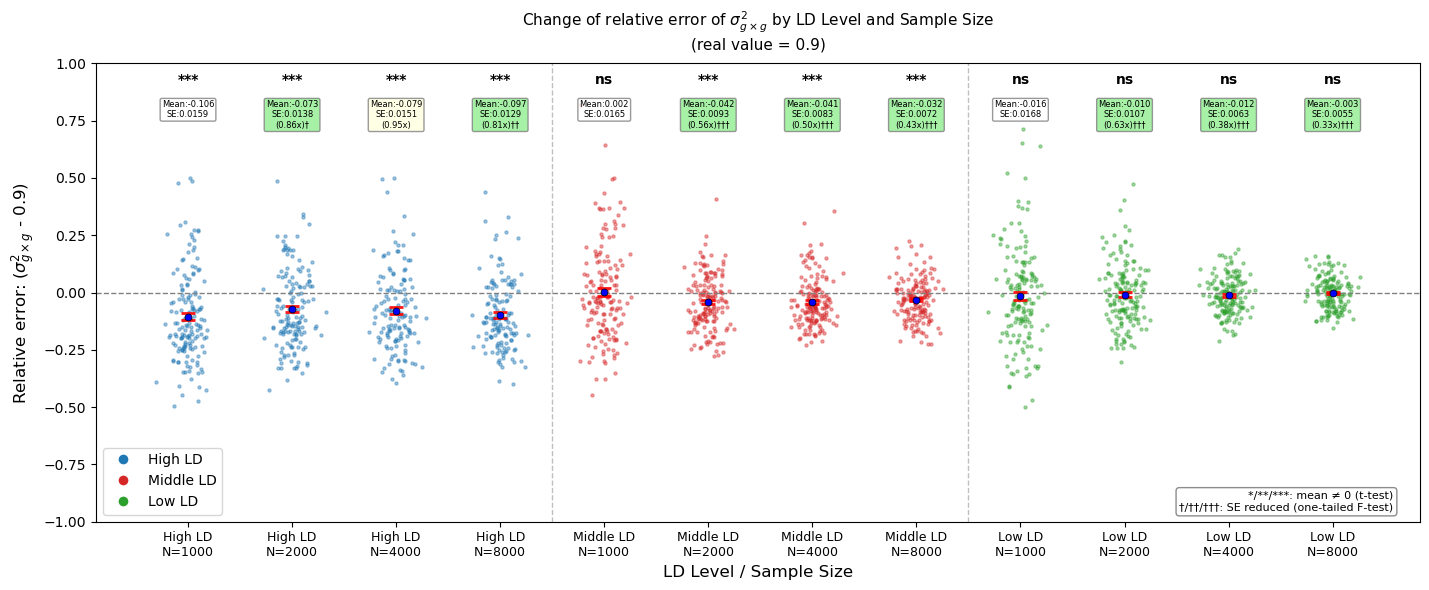

In [3]:
#Experiment 4.1
individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["High LD", "Middle LD", "Low LD"]
plot_relative_error_across_groups_combined(
    highLD_largeDataset_allVariants,
    middleLD_largeDataset_allVariants,
    lowLD_largeDataset_allVariants,
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="LD Level"
)

#### **Experiment 4.1 Summary**

1. **Bias increases with LD level**: The high-LD group exhibited great bias, followed by the middle-LD group, while the low-LD group was nearly unbiased.

2. **Underestimation**: All estimators showed negative bias, which means underestimating the true $h^2_{g \times g}$ value.

3. **Efficiency varies with LD level**: All groups demonstrated improved efficiency (reduced variance) as individual size increased. However, the convergence rate differed across groups: low-LD > middle-LD > high-LD.

4. **Convergence**: The rate of Convergence middle-LD < low-LD group.


#### **Conclusion**:
Greater independence among SNPs leads to more consistent estimators, with improved unbiasedness and efficiency.


#### **Thinking**:
Why does LD level affect estimator efficiency? For a given sample size, the high-LD group exhibits larger standard deviations compared to lower-LD groups.

#### **Experiment 4.2**:
We then invetigate the influence of MAF.

**Hypothesis**:  The MAF will influences the biasness of the epistatic heritability estimator $\hat{h}^2_{g \times g}$, The rarer the variant is, the more biased the estimation will be.
**Simple Inference**: Still from the formule:

$$
\text{Var}(Z_i Z_j) = 1 + \frac{\sigma_{ij}(1 - 2p_i)(1 - 2p_j)}{4p_i p_j (1 - p_i)(1 - p_j)}
$$

Since ld $r_{ij} = \frac{\sigma_{ij}}{\sqrt{p_i p_j (1 - p_i)(1 - p_j)}}$:
$$
\text{Var}(Z_i Z_j) = 1 + \frac{r_{ij}(1 - 2p_i)(1 - 2p_j)}{4\sqrt{p_i p_j (1 - p_i)(1 - p_j)}}
$$

let $f(p_i,p_j) =  \frac{(1 - 2p_i)(1 - 2p_j)}{4\sqrt{p_i p_j (1 - p_i)(1 - p_j)}}$
$$
\text{Var}(Z_i Z_j) = 1 + r_{ij} f(p_i,p_j)
$$

Some property:
1. $f(p_i,p_j) = 0$, when $p_i $ or $p_j $= 0.5

2. $f(p_i,p_j) > 0$, when  both $p_i $ and $p_j $ on the same side( both > 0.5 or  both < 0.5) ; $f(p_i,p_j) < 0$, when they are on
opposite sides

3. $f(p_i,p_j) \to ∞$ when both allele frequencies are extreme (close to 0 or 1), rare variants (close to 0) dramatically inflate ($r_{ij} > 0 $) or deflate ($r_{ij} < 0 $) the $\text{Var}(Z_i Z_j)$

When two SNPs are independent ($r^2 =0, \sigma_{ij} = 0$), the influence of MAF is diminishing, while the dataset is corrected, the low MAF will amplify the effect.


**Test**:
To examine the influence of MAF on estimation bias, we compared six datasets across three LD levels (high, middle, low), each with two MAF conditions (all variants vs. common variants only): highLD_large_all and highLD_large_common, middleLD_large_all and middleLD_large_common, lowLD_large_all and lowLD_large_common.

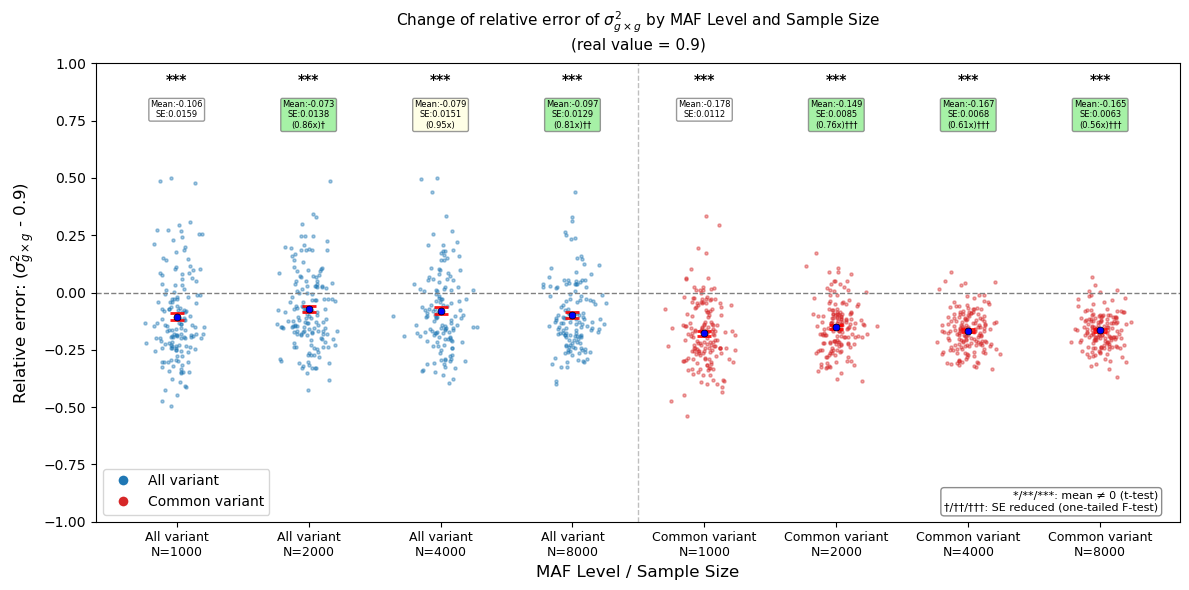

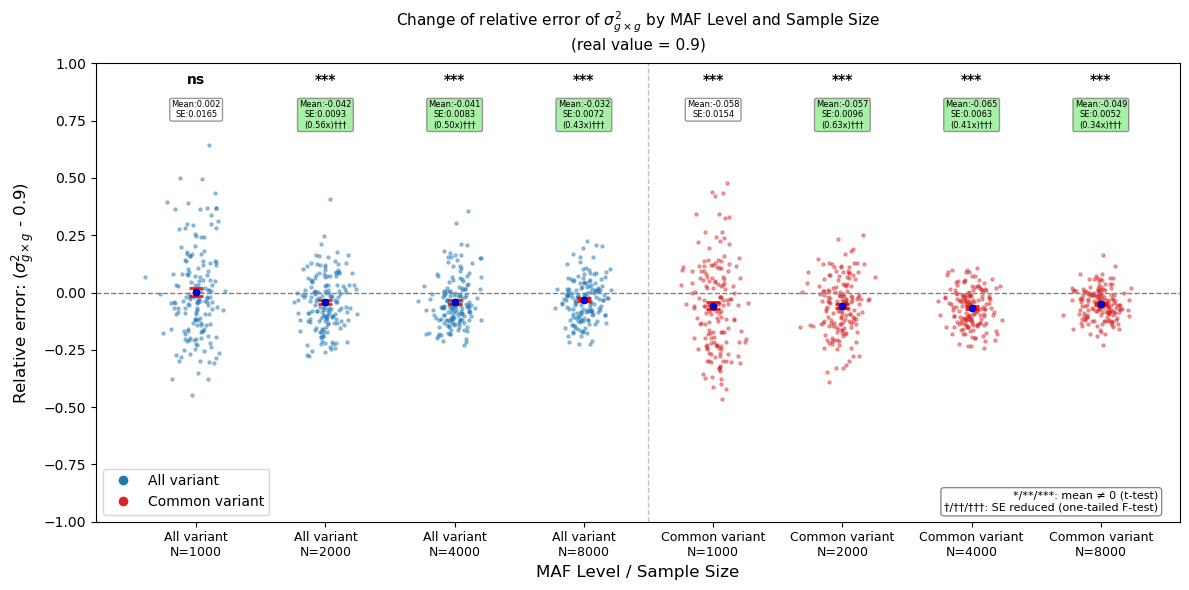

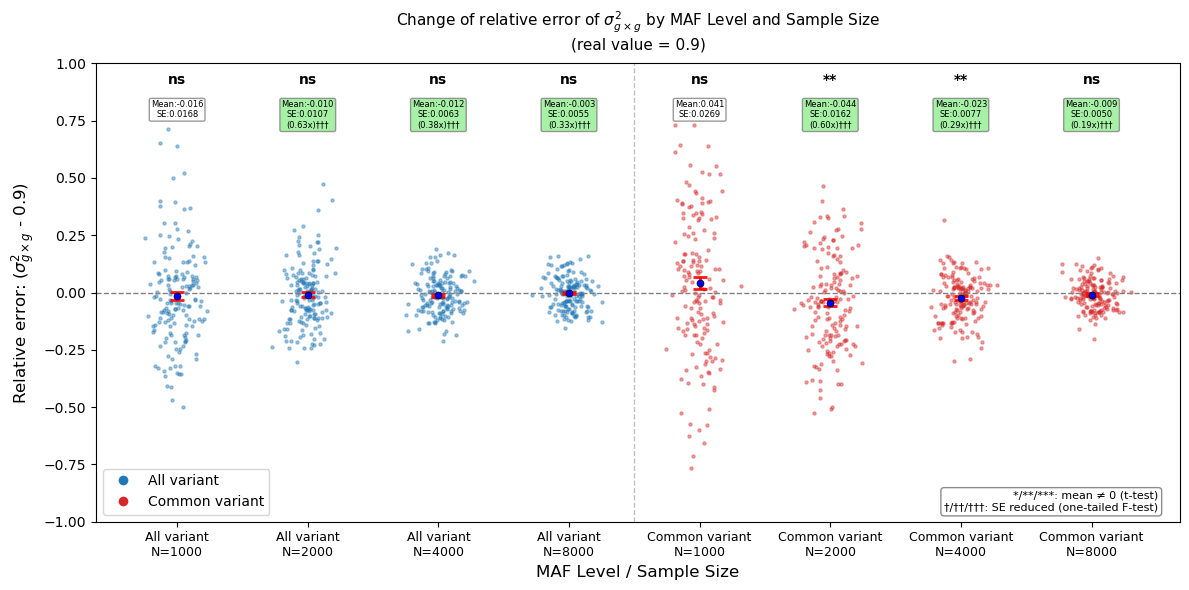

In [9]:
#Experiment 4.2
## highLD group
individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["All variant", "Common variant"]

plot_relative_error_across_groups_combined(
    highLD_largeDataset_allVariants,     
    highLD_largeDataset_commonVariants,  
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="MAF Level"
)


## middleLD group
individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["All variant", "Common variant"]

plot_relative_error_across_groups_combined(
    middleLD_largeDataset_allVariants,     
    middleLD_largeDataset_commonVariants,  
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="MAF Level"
)

## smallLD group
individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["All variant", "Common variant"]

plot_relative_error_across_groups_combined(
    lowLD_largeDataset_allVariants,     
    lowLD_largeDataset_commonVariants,  
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="MAF Level"
)


#### **Experiment 4.2 Summary**:
1. Biasness: as we expected, when data is highly corrected, the bias is amplified (Figure 4.21 vs Figure 4.22), the effect dimishing with the reduce of LD level. However, the common variants groups show higher bias compared with all variants groups.

2. Efficicy: Faster convergence for common variants, under same individual size common variants groups have lower SD (but take a look at Figure4.25 vs Figure4.26), This is reasonable.

#### **Conclusion**:
MAF influences both standard error and efficiency: restricting to common variants reduces variance and improves convergence speed. However, MAF also impacts bias, particularly under high LD conditions, where common variants groups unexpectedly showed greater bias than all variants groups.

#### **Thinking**:
Why do common variants exhibit higher bias than all variants? Is it possible that the common varaints shows higher LD since we use threshold to prune LD

#### **Experiment 4.3**:
We then invetigate the influence of #SNP.

**Hypothesis**:  The #SNP will not influence the bias but will influence the SE.

**Simple Inference**: The number of pairwise products scales as:

$$
\text{Number of pairs} = \frac{M(M-1)}{2} 
$$


Fewer SNPs → higher SE as the infomation is lost
More SNPs → less SE as more precise the MoM

**Test**:
To examine the influence of #SNP on estimation, we compared six datasets across three LD levels (high, middle, low), each with two #SNP conditions (large dataset vs. small dataset): highLD_large_all and highLD_small_all, middleLD_large_all and middleLD_small_all, lowLD_large_all and lowLD_small_all.

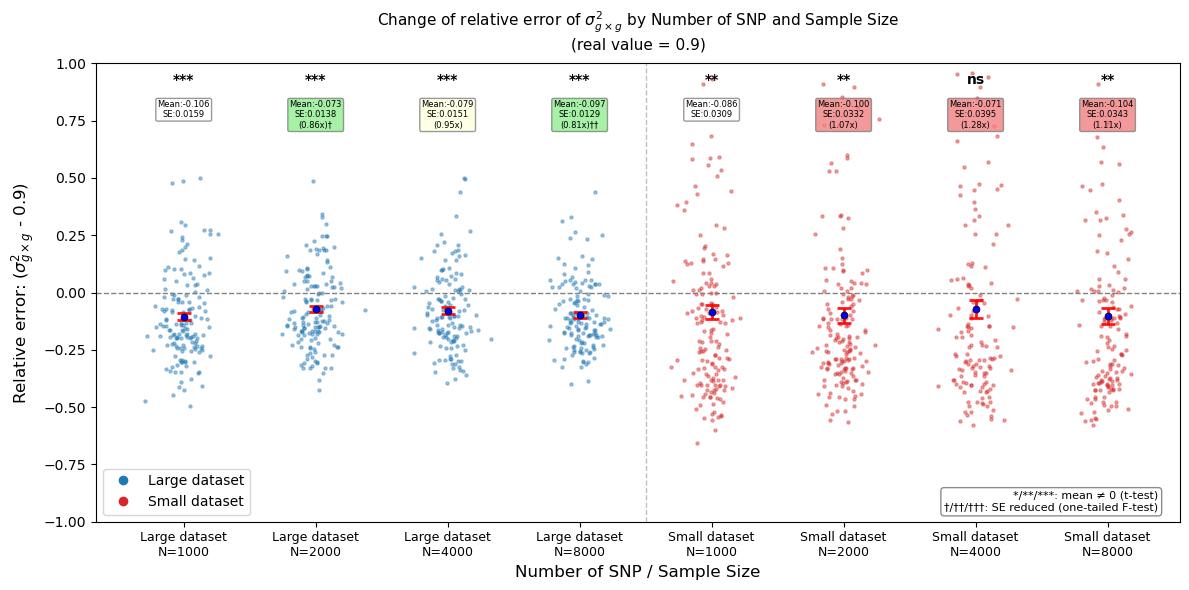

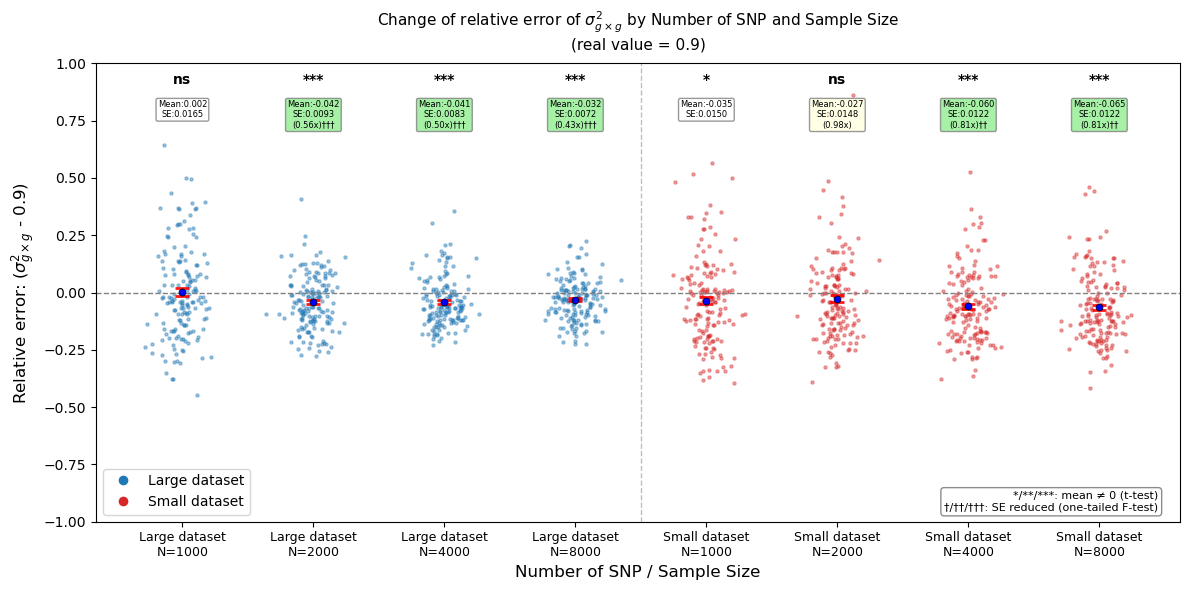

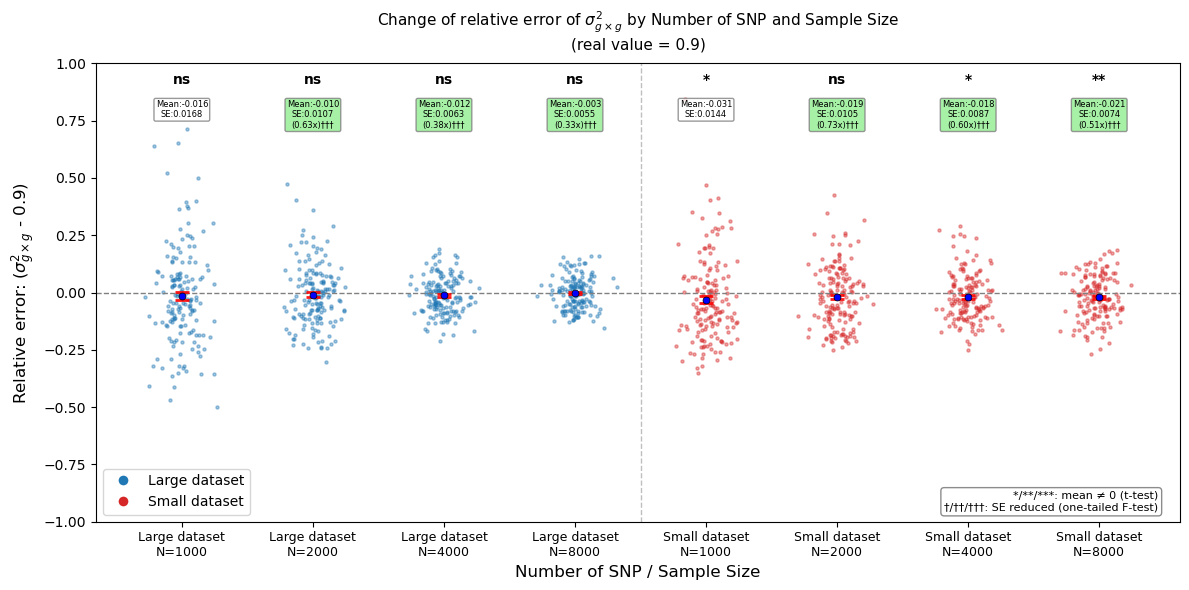

In [11]:
## highLD group

individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["Large dataset", "Small dataset"]

plot_relative_error_across_groups_combined(
    highLD_largeDataset_allVariants,     
    highLD_smallDataset_allVariants,  
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="Number of SNP"
)
## middleLD group
individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["Large dataset", "Small dataset"]

plot_relative_error_across_groups_combined(
    middleLD_largeDataset_allVariants,     
    middleLD_smallDataset_allVariants,  
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="Number of SNP"
)

## lowLD group
individual_sizes = [1000, 2000, 4000, 8000]
x_labels = ["Large dataset", "Small dataset"]

plot_relative_error_across_groups_combined(
    lowLD_largeDataset_allVariants,     
    lowLD_smallDataset_allVariants,  
    x_labels=x_labels,
    individual_sizes=individual_sizes,
    col_num=0,
    real_value=0.9,
    ymin=-1,
    ymax=1,
    x_axis_name="Number of SNP"
)

------------------Figure4.5 middle LD_Large dataset_All variants case-------------------


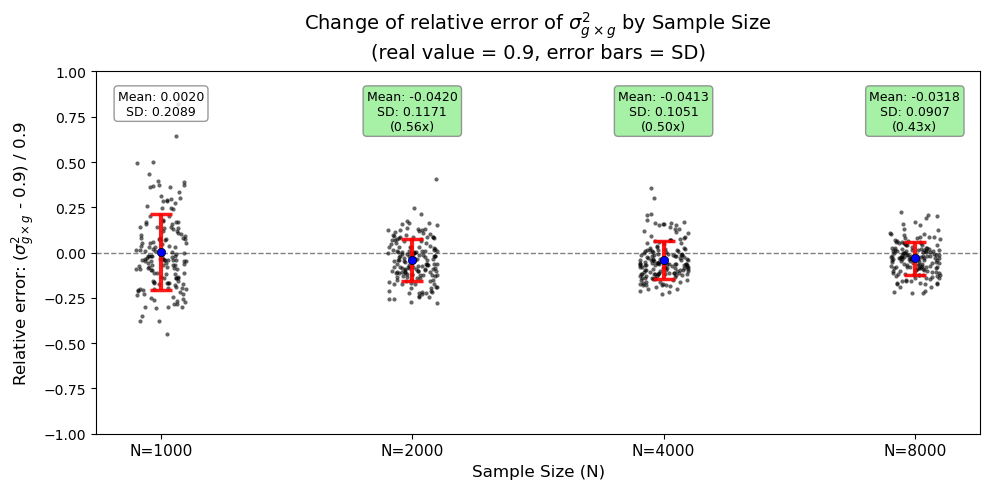

------------------Figure4.7 middle LD_small dataset_All variants case-------------------


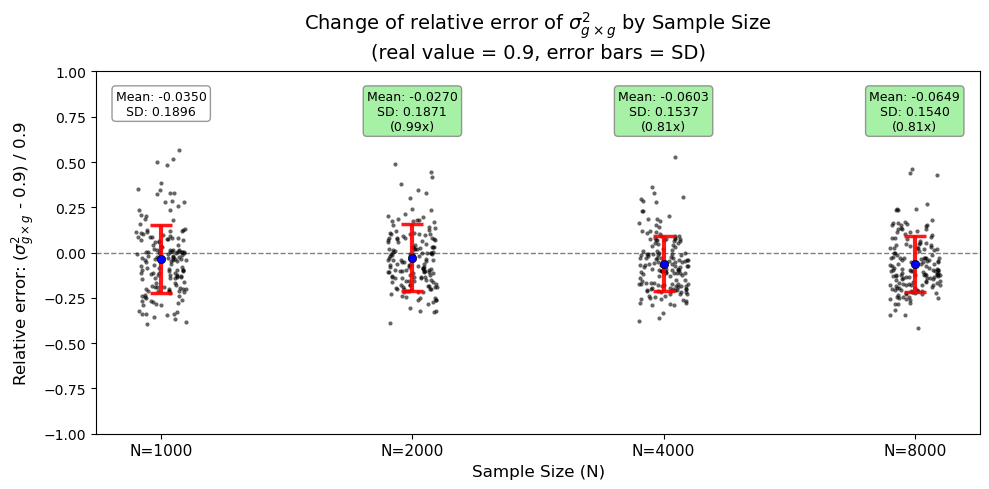

In [4]:
## middle group
individual_sizes = [1000,2000,4000,8000]
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_largeDataset_allVariants/",1800)
MLA = [middleLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.5 middle LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


middleLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_smallDataset_allVariants/",600)
MSA = [middleLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.7 middle LD_small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)

------------------Figure4.9 small LD_Large dataset_All variants case-------------------


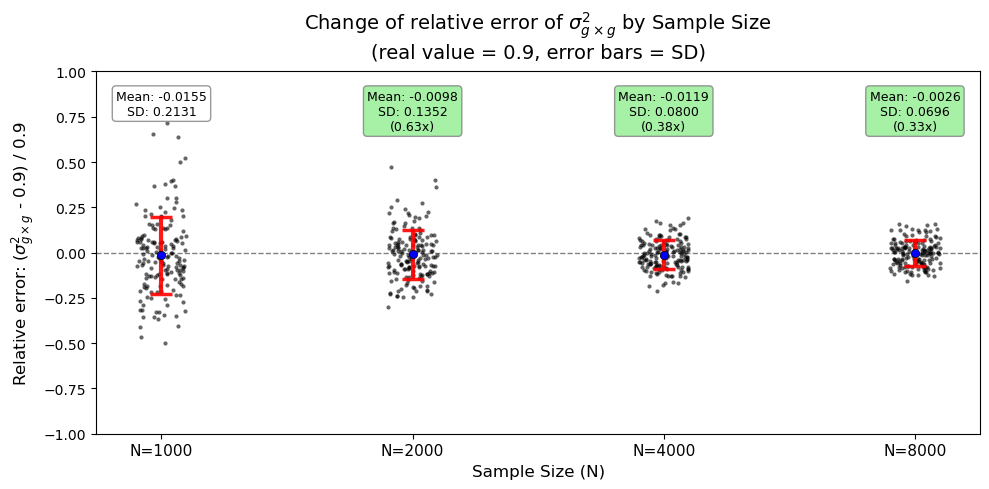

------------------Figure4.11 small LD_small dataset_All variants case-------------------


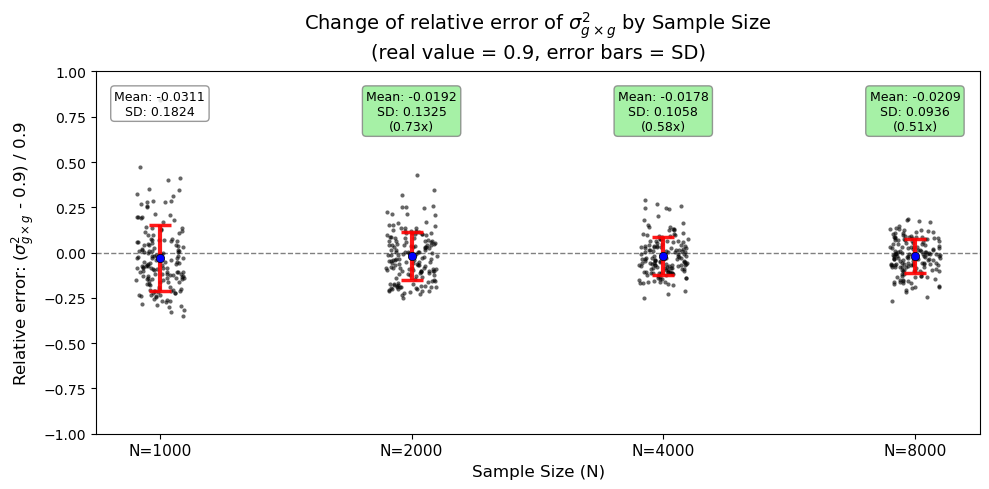

In [5]:
## low LD group
individual_sizes = [1000,2000,4000,8000]
lowLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_largeDataset_allVariants/",1800)
LLA = [lowLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.9 small LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *LLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


lowLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_smallDataset_allVariants/",600)
LSA = [lowLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.11 small LD_small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *LSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)



#### **Experiment 4.3 Summary**:
1. Biasness: The #SNP has negligible influence in biasness, with infinite replicates, the bias of large dataset should equal to small dataset 

2. Efficicy: The method shows faster convergence for large datasets. Under the same sample size, large datasets groups have lower standard errors, which aligns with our expectations. Additionally, the benefit of larger datasets is more pronounced when LD levels are lower.

#### **Conclusion**:
#SNP affects efficiency but not bias. While larger datasets provide lower standard errors and faster convergence, particularly under low LD , the expected heritability estimate remains unbiased regardless of SNP number.

#### **Thinking**:
Is it possible that for a small dataset, the noise caused by #SNP itself has dominate the standard, rather than the stochastic algorithm?



##  Summary table (Fixed N)

## Relative Error of Heritability Estimates Across LD Levels, MAF, and Sample Sizes

*Values shown as Mean (SD) of relative error; true $\sigma^2_{g \times g} = 0.9$*

| LD level | MAF | #SNP | N = 1K | N = 2K | N = 4K | N = 8K |
|:--------:|:---:|:----:|:------:|:------:|:------:|:------:|
| $r^2<0.9$ | all | 1800 | -0.106(0.195) | -0.073(0.168) | -0.079(0.177) | -0.097(0.151) |
|  |  | 600 | -0.086(0.390) | -0.100(0.420) | -0.071(0.462) | -0.104(0.413) |
|  | only common | 1800 | -0.178(0.141) | -0.149(0.107) | -0.167(0.086) | -0.165(0.077) |
|  |  | 600 | -0.239(0.174) | -0.241(0.144) | -0.225(0.159) | -0.247(0.148) |
| $r^2<0.5$ | all | 1800 | 0.002(0.209) | -0.042(0.117) | -0.041(0.105) | -0.032(0.091) |
|  |  | 600 | -0.035(0.190) | -0.027(0.187) | -0.060(0.154) | -0.065(0.154) |
|  | only common | 1800 | -0.058(0.195) | -0.057(0.122) | -0.066(0.080) | -0.050(0.066) |
|  |  | 600 | -0.107(0.169) | -0.105(0.117) | -0.103(0.093) | -0.102(0.083) |
| $r^2<0.2$ | all | 1800 | -0.016(0.213) | -0.010(0.135) | -0.012(0.080) | -0.003(0.070) |
|  |  | 600 | -0.031(0.182) | -0.019(0.133) | -0.018(0.106) | -0.021(0.094) |
|  | only common | 1800 | 0.041(0.340) | -0.044(0.205) | -0.023(0.097) | -0.009(0.064) |
|  |  | 600 | -0.021(0.187) | -0.050(0.114) | -0.040(0.077) | -0.028(0.065) |


------------------Figure4.1 High LD_Large dataset_All variants case-------------------


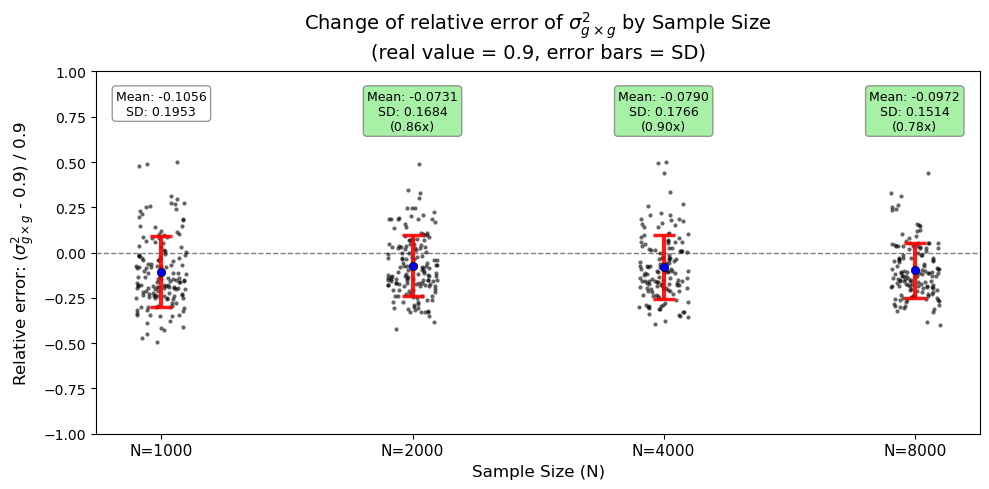

------------------Figure4.2 High LD_Large dataset_Common variants case-------------------


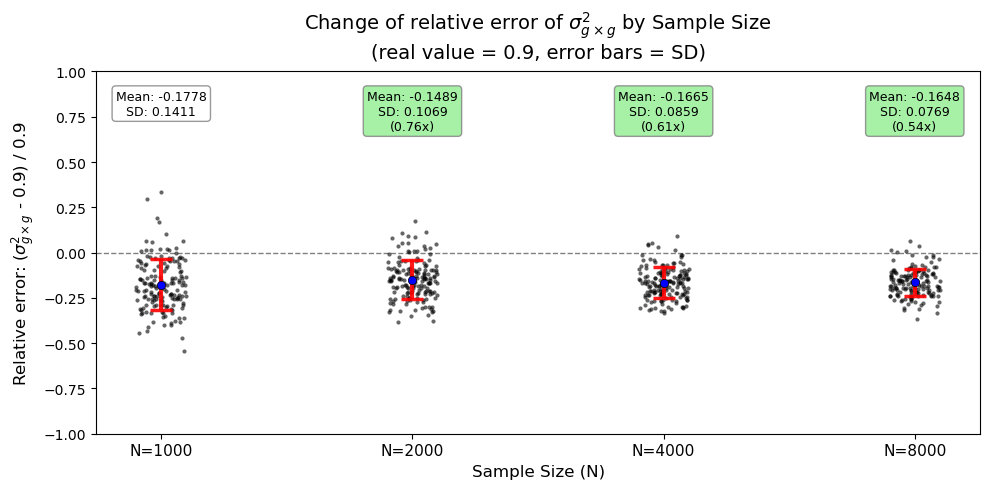

------------------Figure4.3 High LD_Small dataset_All variants case-------------------


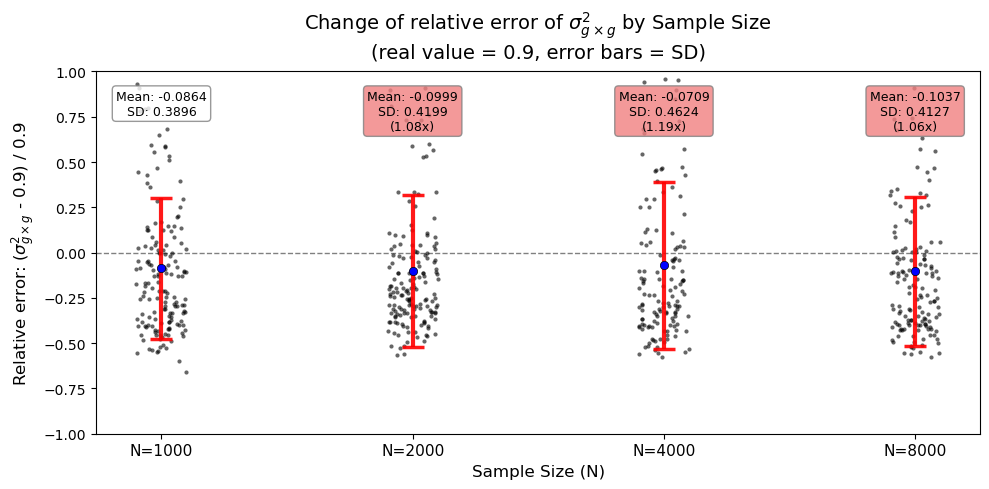

------------------Figure4.4 High LD_Small dataset_Common variants case-------------------


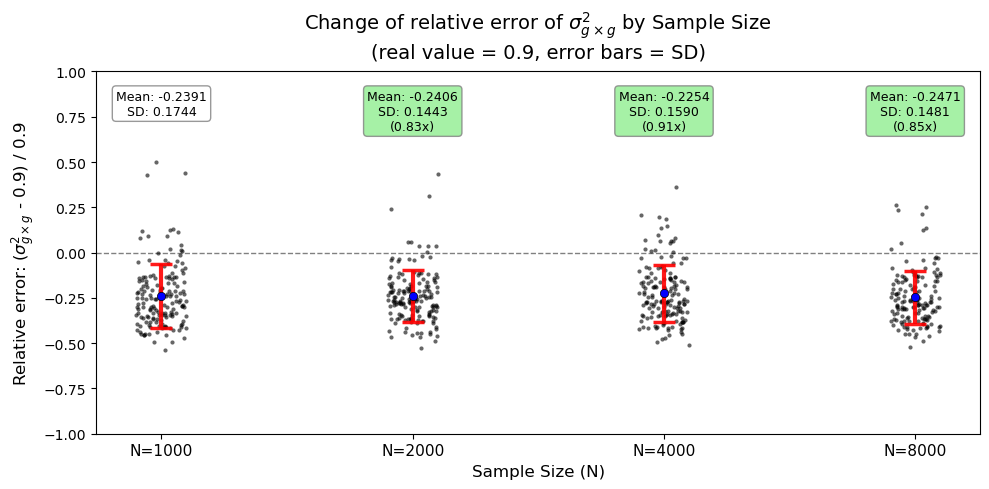

In [7]:
## highLD group

individual_sizes = [1000,2000,4000,8000]
highLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_largeDataset_allVariants/",1800)
HLA = [highLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.1 High LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *HLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


highLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_largeDataset_commonVariants/",1800)
HLC = [highLD_largeDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.2 High LD_Large dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *HLC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


highLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_smallDataset_allVariants/",600)
HSA = [highLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.3 High LD_Small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *HSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


highLD_smallDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/highLD_smallDataset_commonVariants/",600)
HSC = [highLD_smallDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.4 High LD_Small dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *HSC, 
    basic_individual=1000, col_num=0, real_value=0.9, ymin=-1,ymax =1
)




------------------Figure4.5 middle LD_Large dataset_All variants case-------------------


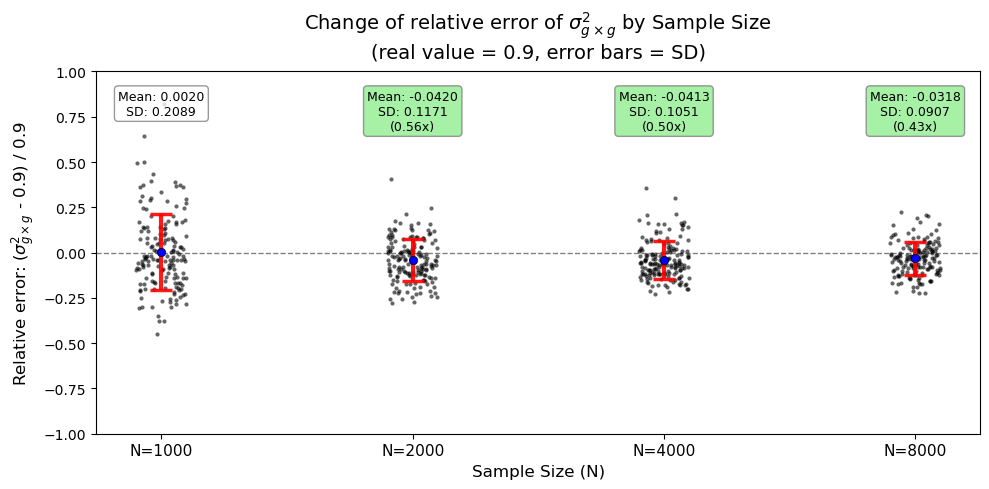

------------------Figure4.6 middle LD_Large dataset_Common variants case-------------------


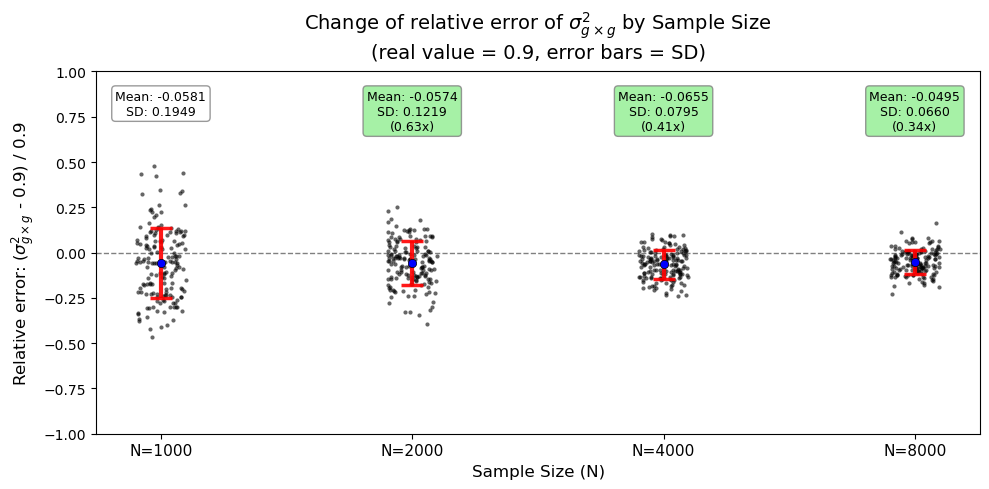

------------------Figure4.7 middle LD_small dataset_All variants case-------------------


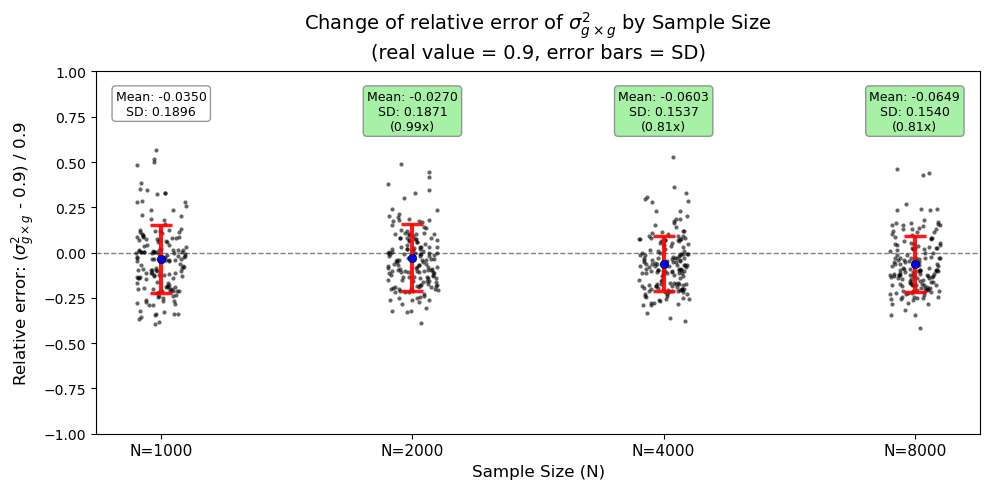

------------------Figure4.8 middle LD_small dataset_Common variants case-------------------


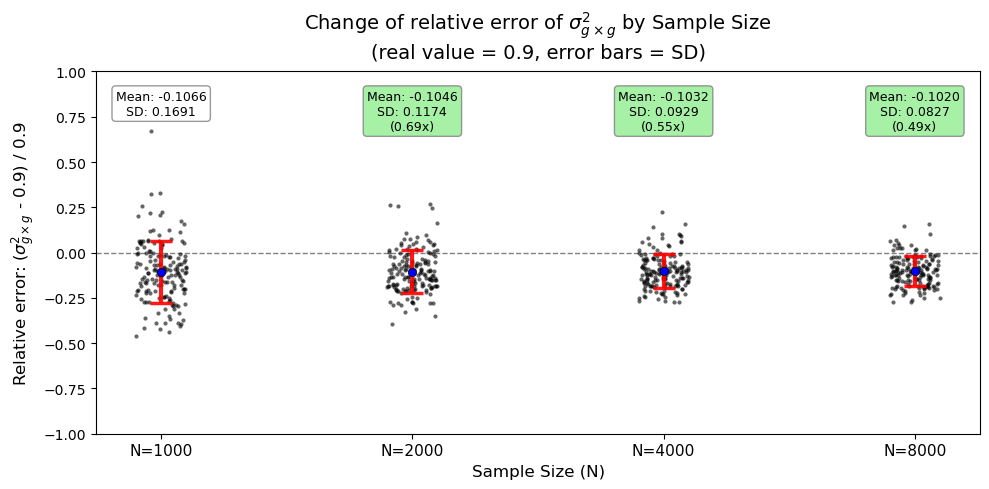

In [11]:
## middle group
individual_sizes = [1000,2000,4000,8000]
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_largeDataset_allVariants/",1800)
MLA = [middleLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.5 middle LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)

middleLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_largeDataset_commonVariants/",1800)
MLC = [middleLD_largeDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.6 middle LD_Large dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


middleLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_smallDataset_allVariants/",600)
MSA = [middleLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.7 middle LD_small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


middleLD_smallDataset_comonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/middleLD_smallDataset_comonVariants/",600)
MSC = [middleLD_smallDataset_comonVariants[n] for n in individual_sizes]

print("------------------Figure4.8 middle LD_small dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *MSC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)



------------------Figure4.9 small LD_Large dataset_All variants case-------------------


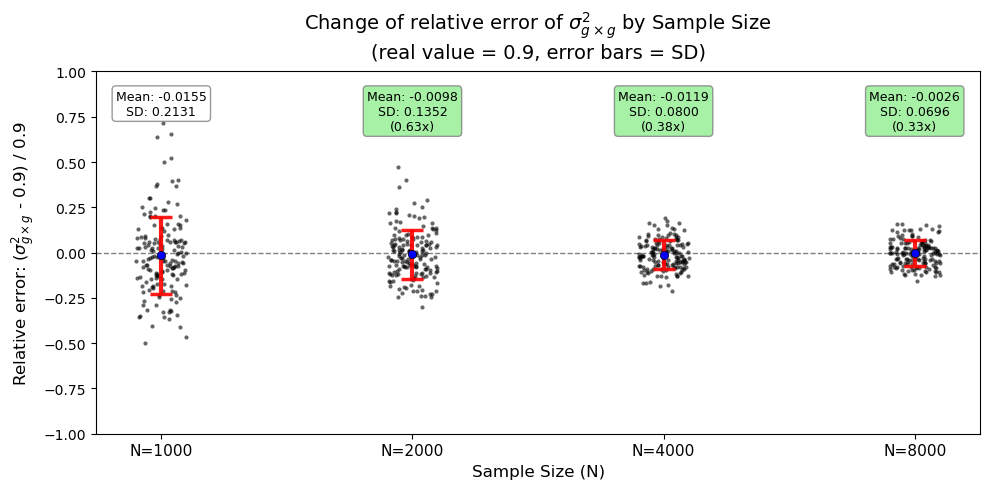

------------------Figure4.10 small LD_Large dataset_Common variants case-------------------


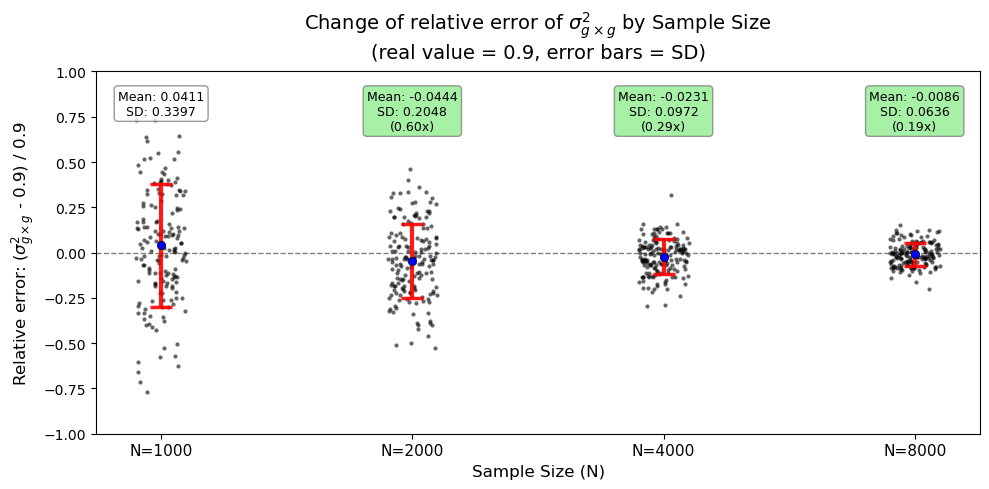

------------------Figure4.11 small LD_small dataset_All variants case-------------------


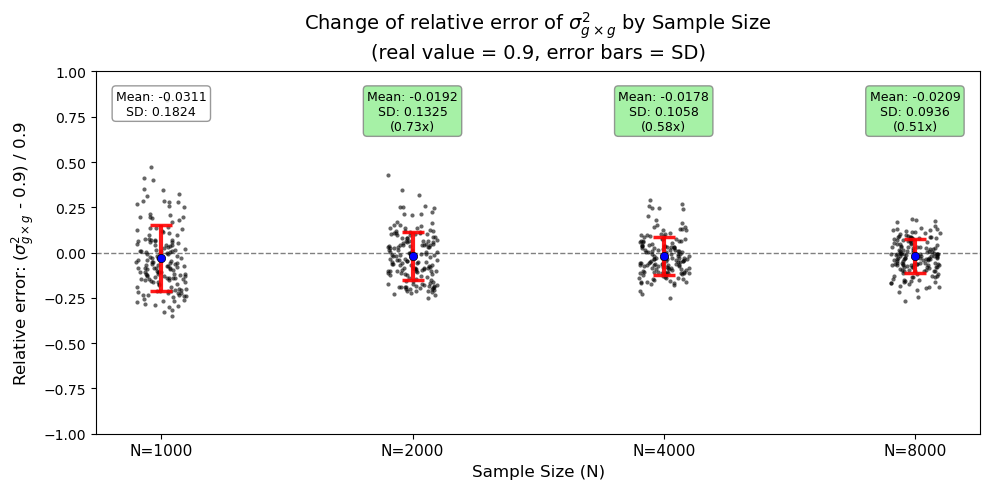

------------------Figure4.12 small LD_small dataset_Common variants case-------------------


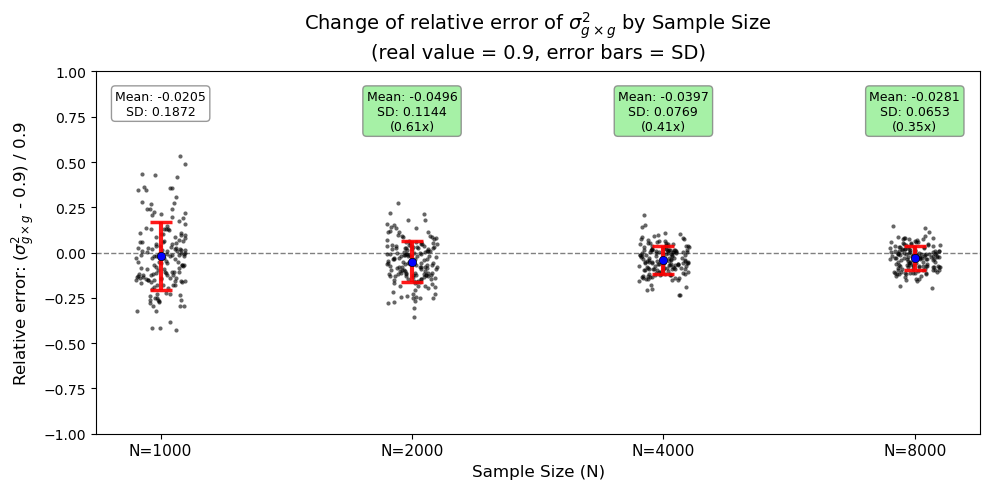

In [9]:
## low LD group
individual_sizes = [1000,2000,4000,8000]
lowLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_largeDataset_allVariants/",1800)
LLA = [lowLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.9 small LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *LLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)

lowLD_largeDataset_commonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_largeDataset_commonVariants/",1800)
LLC = [lowLD_largeDataset_commonVariants[n] for n in individual_sizes]

print("------------------Figure4.10 small LD_Large dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *LLC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


lowLD_smallDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_smallDataset_allVariants/",600)
LSA = [lowLD_smallDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure4.11 small LD_small dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *LSA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


lowLD_smallDataset_comonVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result/lowLD_smallDataset_commonVariants/",600)
LSC = [lowLD_smallDataset_comonVariants[n] for n in individual_sizes]

print("------------------Figure4.12 small LD_small dataset_Common variants case-------------------")
plot_relative_error_accross_sample_size(
    *LSC, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)



#### Figure summary :
**LD**:
Based on the figures, we observe that standard error decreases with increasing sample size in the medium and low LD groups, but not in the high LD group. Both high and medium LD groups exhibit substantial bias, whereas bias is not clearly distinguishable in the low LD group. Overall, low LD outperforms medium LD, which in turn outperforms high LD for GxG estimation.

**MAF**:
Filtering out low-frequency variants shows no clear benefit for GxG estimation. In the low LD group, using all variants versus common variants produces nearly same results. However, in medium and high LD settings, MAF filtering increases bias, leading to underestimation (compare Figures 4.4 vs 4.3, 4.1 vs 4.2, and 4.7 vs 4.8).


**SNP number**:
Based on the plots, the number of SNPs does not affect bias, but its effect on standard error depends on LD level. In the low LD group, fewer SNPs yield lower standard error (Figures 4.12 vs 4.10, 4.11 vs 4.09). Conversely, in the high LD group, fewer SNPs result in higher standard error (Figures 4.4 vs 4.2, 4.3 vs 4.1).

------------------Figure 4.12 middle LD_Large dataset_All variants case-------------------


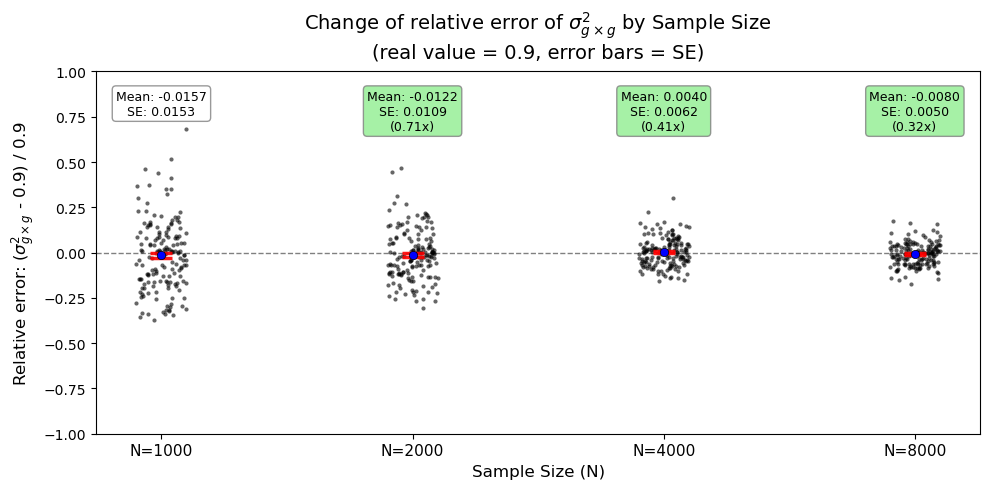

------------------Figure 4.12 middle LD_Large dataset_All variants case-------------------


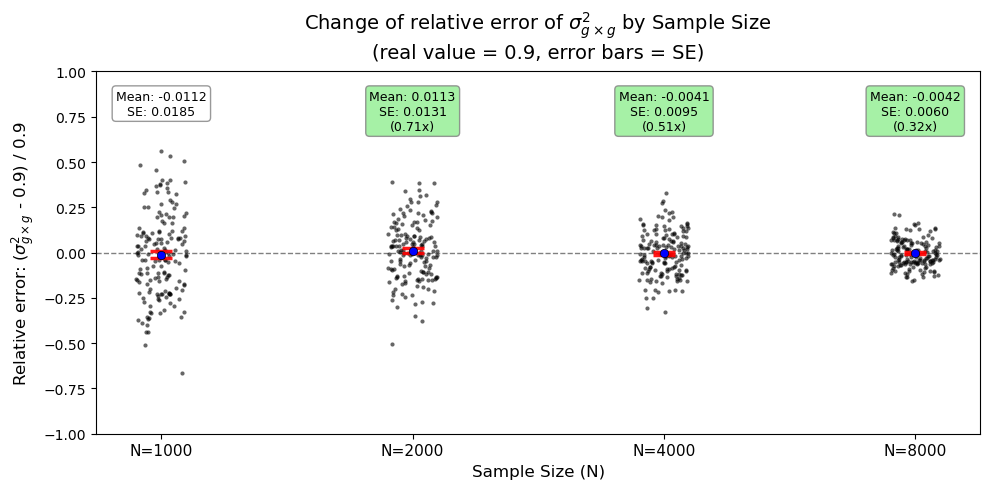

------------------Figure 4.12 middle LD_Large dataset_All variants case-------------------


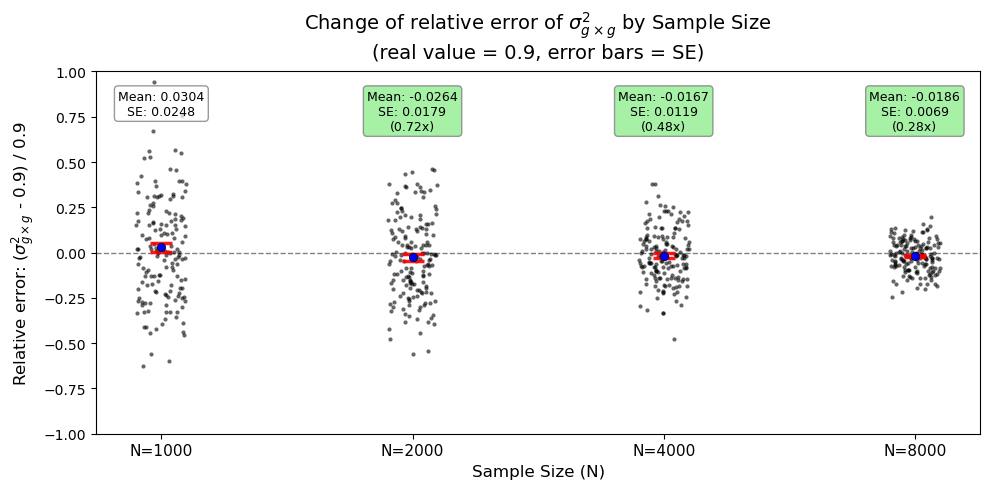

In [8]:
individual_sizes = [1000,2000,4000,8000]
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",500)
MLA = [middleLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure 4.12 middle LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)

individual_sizes = [1000,2000,4000,8000]
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",1000)
MLA = [middleLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure 4.12 middle LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)


individual_sizes = [1000,2000,4000,8000]
middleLD_largeDataset_allVariants = read_MoM_results(individual_sizes,"../test_data/All_simulation_result","independent",2000)
MLA = [middleLD_largeDataset_allVariants[n] for n in individual_sizes]

print("------------------Figure 4.12 middle LD_Large dataset_All variants case-------------------")
plot_relative_error_accross_sample_size(
    *MLA, 
    basic_individual=1000, col_num=0, real_value=0.9,ymin=-1,ymax =1
)